# Solve Diffusion equation 
$ \partial_t u = \nabla^2 u $

## Decompose $u$ in homogeneous and inhomogeneous (BC) part
$ \partial_t u_h = \nabla^2 u_h + \nabla^2 u_{bc} $


In [43]:
%load_ext autoreload
%autoreload 2
from pypde import *
import numpy as np
import matplotlib.pyplot as plt

N,M = 20,30
shape = (N,M)

dt = 0.1
kappa = 1.0
lam = dt*kappa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Field

In [44]:
u = Field(shape,("CD","CD"))
x,y = u.x, u.y
xx,yy = np.meshgrid(x,y,indexing="ij")

# boundary conditions along x
bc = np.zeros((2,M))
bc[0,:] = np.cos(np.pi*y)

ubc = FieldBC(shape,("CD","CN"),axis=0)
ubc.add_bc(bc)

# get second derivative of ubc
dubc = derivative_field(ubc,deriv=(0,2))
ubc = derivative_field(ubc,deriv=(0,0))

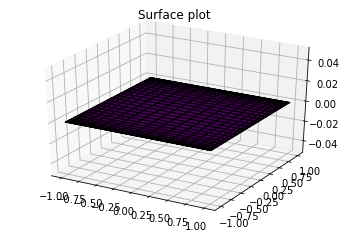

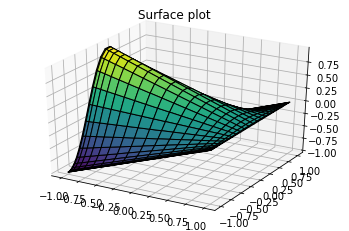

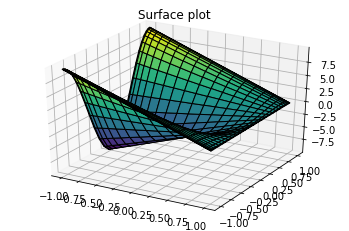

In [45]:
plot(xx,yy,u.v)
plot(xx,yy,ubc.v)
plot(xx,yy,dubc.v)

## Matrices

In [55]:
from pypde.bases import *

# --- Matrices ----
Sx = u.xs[0].S_sp
Bx = u.xs[0].family.B(2,2)
Ix = u.xs[0].family.I(2)
Ax =  Bx@Sx-lam*Ix@Sx

Sy = u.xs[1].S_sp
By = u.xs[1].family.B(2,2)
Iy = u.xs[1].family.I(2)
Ay =  By@Sy-lam*Iy@Sy

#plt.spy(Ay)
#plt.show()

## Plans

In [56]:
# Add them
solver = SolverPlan()
solver.add_rhs(PlanRHS(Bx@Sx,ndim=2,axis=0))
solver.add_rhs(PlanRHS(By@Sy,ndim=2,axis=1))

solver.add_lhs( PlanLHS(Ax,ndim=2,axis=0,method="numpy") )
solver.add_lhs( PlanLHS(Ay,ndim=2,axis=1,method="numpy") )

solver.show_plan()

Plans RHS:
1 ) Apply method 'multiply' along axis 0 
2 ) Apply method 'multiply' along axis 1 

Plans LHS:
1 ) Apply method 'numpy' along axis 0 
2 ) Apply method 'numpy' along axis 1 



## Solve


In [57]:
def _f(xx,yy):
        ''' Forcing Functions'''
        return np.cos(1*np.pi/2*xx)*np.cos(1*yy)
    
force = Field(shape,("CD","CD"))
force.v = _f(xx,yy)
force.forward()

In [68]:


def update():
    #b = lam*dubc.vhat + Sx@u.vhat@Sy.T
    b = dt*force.vhat + u.vhat
    # Solve them
    rhs = solver.solve_rhs(b)
    u.vhat[:] = solver.solve_lhs(rhs)

u.vhat[:] = 0
for i in range(10):
    update()

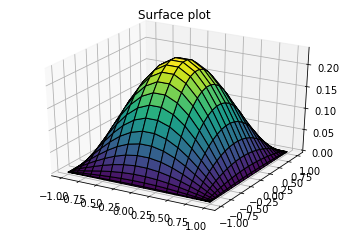

In [69]:
u.backward()
#plot(xx,yy,ubc.v)
plot(xx,yy,u.v)


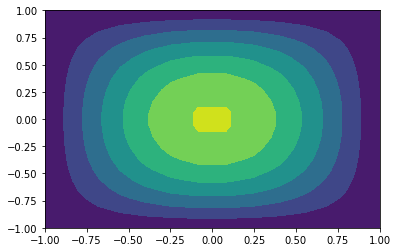

In [60]:
plt.contourf(xx,yy,u.v)
plt.show()

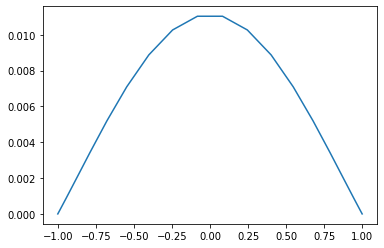

In [61]:
plt.plot(x,(u.v)[:,2])
#plt.plot(y,(u.v+ubc.v)[1,:])